In [ ]:
!pip install transformers
!pip install torch
!pip install datasets
!pip install tqdm
!pip install rouge

from sklearn.metrics.pairwise import cosine_similarity
from datasets import Dataset, DatasetDict, load_dataset
from huggingface_hub import login
from transformers import AutoModelForCausalLM, AutoTokenizer, BertTokenizer, BertModel, AutoTokenizer, AutoModel
from tqdm import tqdm
from sklearn.metrics import cohen_kappa_score
from rouge import Rouge

import json
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import numpy as np
import random
import torch
import re
import transformers
import seaborn as sns

login(token="xxx")
base = '-self'

DATASET LOADING

In [ ]:
dataset_gemma = load_dataset("Ramitha/sl-results-40-gemma" + base)
df_gemma = pd.DataFrame(dataset_gemma['rawcases'])
dataset_llama = load_dataset("Ramitha/sl-results-40-llama" + base)
df_llama = pd.DataFrame(dataset_llama['rawcases'])
dataset_falcon = load_dataset("Ramitha/sl-results-40-falcon" + base)
df_falcon = pd.DataFrame(dataset_falcon['rawcases'])
dataset_mistral = load_dataset("Ramitha/sl-results-40-mistral" + base)
df_mistral = pd.DataFrame(dataset_mistral['rawcases'])

In [ ]:
gold_standard_cos_dict = {"gemma": df_gemma["gold_standard_cos"].mean(),
                                "llama": df_llama["gold_standard_cos"].mean(),
                                "falcon": df_falcon["gold_standard_cos"].mean(),
                                "mistral": df_mistral["gold_standard_cos"].mean()}
cosine_score_mean_dict = {"gemma": df_gemma["ILRSim"].mean(),
                                "llama": df_llama["ILRSim"].mean(),
                                "falcon": df_falcon["ILRSim"].mean(),
                                "mistral": df_mistral["ILRSim"].mean()}
iaa_dict = {"gemma": df_gemma["iaa_fleiss_kappa"].mean(),
                                "llama": df_llama["iaa_fleiss_kappa"].mean(),
                                "falcon": df_falcon["iaa_fleiss_kappa"].mean(),
                                "mistral": df_mistral["iaa_fleiss_kappa"].mean()}
iaa_agreement_dict = {"gemma": df_gemma["iaa_fleiss_kappa_agreement"].mean(),
                                "llama": df_llama["iaa_fleiss_kappa_agreement"].mean(),
                                "falcon": df_falcon["iaa_fleiss_kappa_agreement"].mean(),
                                "mistral": df_mistral["iaa_fleiss_kappa_agreement"].mean()}
reconstruction_error_mean_dict = {"gemma": df_gemma["ILRError"].mean(),
                                "llama": df_llama["ILRError"].mean(),
                                "falcon": df_falcon["ILRError"].mean(),
                                "mistral": df_mistral["ILRError"].mean()}
case_alignment_dict = {"gemma": df_gemma["ILRAlign"].mean(),
                                "llama": df_llama["ILRAlign"].mean(),
                                "falcon": df_falcon["ILRAlign"].mean(),
                                "mistral": df_mistral["ILRAlign"].mean()}
question_bm25_score_mean_dict = {"gemma": df_gemma["question_bm25_score_mean"].mean(),
                                "llama": df_llama["question_bm25_score_mean"].mean(),
                                "falcon": df_falcon["question_bm25_score_mean"].mean(),
                                "mistral": df_mistral["question_bm25_score_mean"].mean()}
question_rouge_score_mean_dict = {"gemma": df_gemma["question_rouge_score_mean"].mean(),
                                "llama": df_llama["question_rouge_score_mean"].mean(),
                                "falcon": df_falcon["question_rouge_score_mean"].mean(),
                                "mistral": df_mistral["question_rouge_score_mean"].mean()}
question_bleu_score_mean_dict = {"gemma": df_gemma["question_bleu_score_mean"].mean(),
                                "llama": df_llama["question_bleu_score_mean"].mean(),
                                "falcon": df_falcon["question_bleu_score_mean"].mean(),
                                "mistral": df_mistral["question_bleu_score_mean"].mean()}

In [ ]:
def get_key_temperatures(grouped_data):
    sorted_data = grouped_data.sort_values(by='gold_standard_cos')
    lowest_temp = sorted_data.idxmin()['gold_standard_cos']
    lowest_value = sorted_data.min()['gold_standard_cos']
    highest_temp = sorted_data.idxmax()['gold_standard_cos']
    highest_value = sorted_data.max()['gold_standard_cos']
    avg_value = sorted_data['gold_standard_cos'].mean()
    avg_temp = (sorted_data['gold_standard_cos'] - avg_value).abs().idxmin()
    return lowest_temp, avg_temp, highest_temp

GEMMA AS A MODEL

Sample count 400


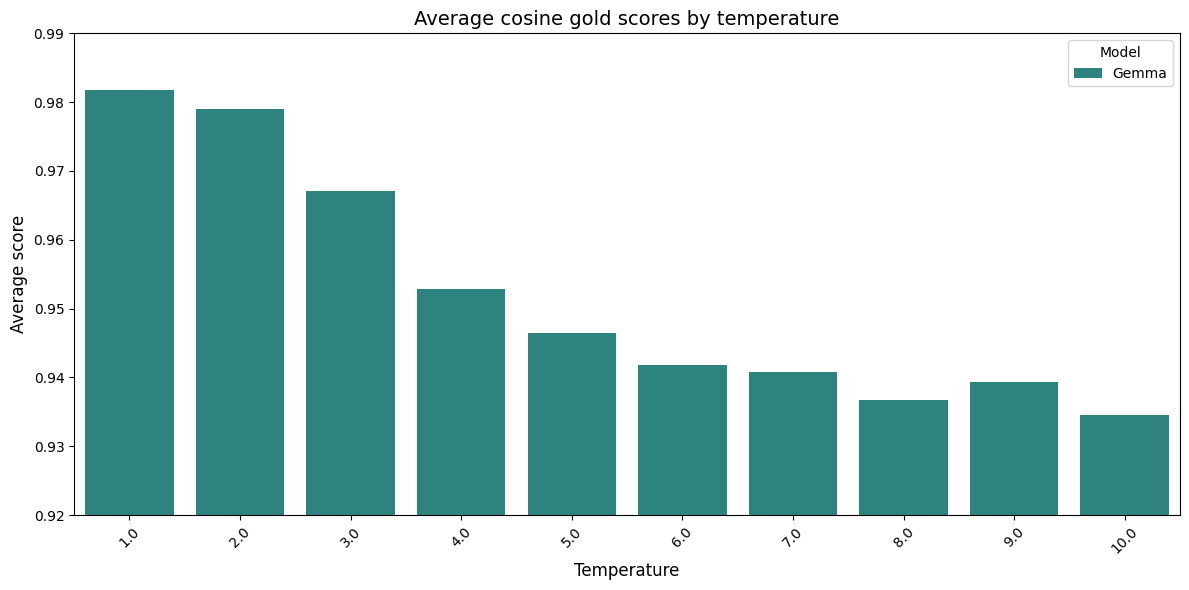

In [ ]:
start_index = 0
end_index = 400
print('Sample count', end_index - start_index)
df_gemma = df_gemma[start_index: end_index]
grouped_gemma = df_gemma.groupby('temperature')[['gold_standard_cos']].mean()
grouped_gemma['Model'] = 'Gemma'
all_grouped_scores = pd.concat(
    [
        grouped_gemma
    ]
)
all_grouped_scores = all_grouped_scores.reset_index()
melted_scores = all_grouped_scores.melt(
    id_vars=['temperature', 'Model'],
    var_name='Metric',
    value_name='Average'
)
plt.figure(figsize=(12, 6))
sns.barplot(
    x='temperature',
    y='Average',
    hue='Model',
    data=melted_scores,
    palette='viridis'
)
plt.title('Average cosine gold scores by temperature', fontsize=14)
plt.ylabel('Average score', fontsize=12)
plt.ylim(0.92, 0.99)
plt.xlabel('Temperature', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

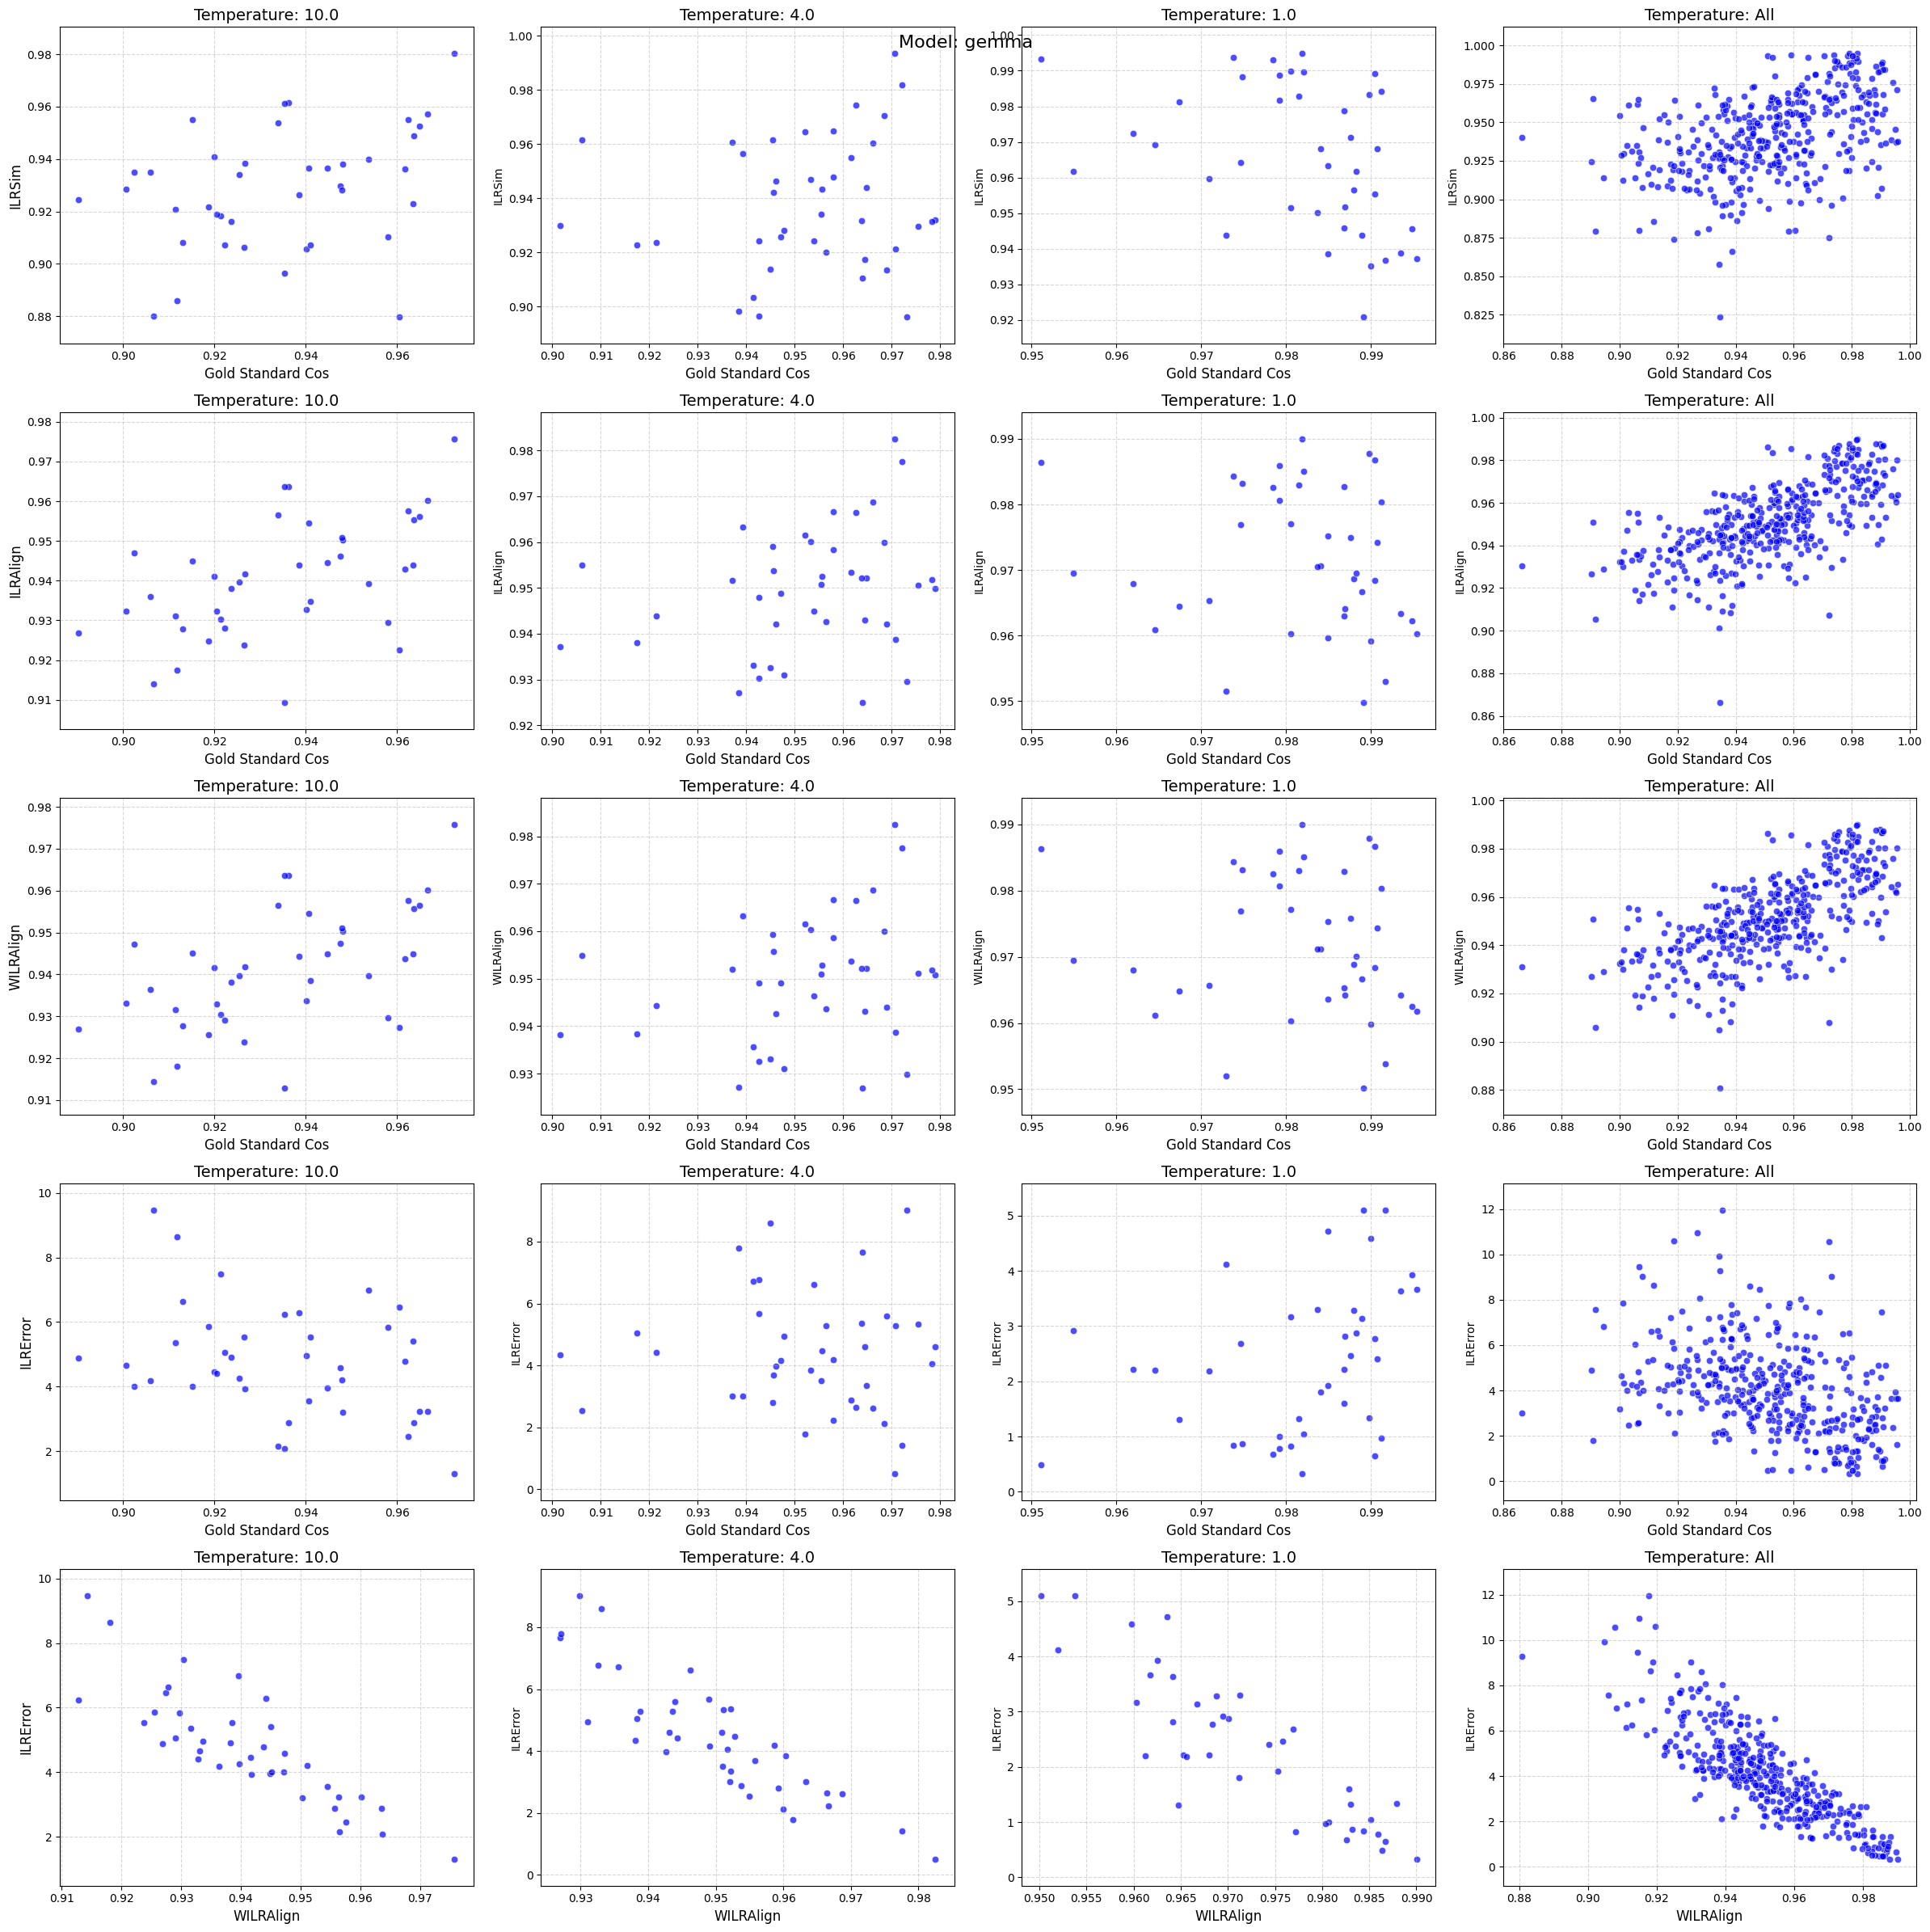

In [ ]:
gemma_values = get_key_temperatures(grouped_gemma)
gemma_temperature_selection = [gemma_values[0], gemma_values[1], gemma_values[2]]
temperature_selections = {
    'gemma': (gemma_temperature_selection, df_gemma)
}

max_temps = max(len(temp_selection) for temp_selection, _ in temperature_selections.values()) + 1

for model, (temp_selection, df) in temperature_selections.items():
    fig, axes = plt.subplots(5, max(len(temp_selection) + 1, max_temps),
                              figsize=((max_temps) * 6, 4 * 6),
                              sharey=False)

    def get_dynamic_limits(data, y_column):
        min_val, max_val = data[y_column].min(), data[y_column].max()
        margin = (max_val - min_val) * 0.1
        return min_val - margin, max_val + margin

    for row, y_column, y_label in zip(
        range(6),
        ['ILRSim', 'ILRAlign', 'WILRAlign', 'ILRError', 'ILRError'],
        ['ILRSim', 'ILRAlign', 'WILRAlign', 'ILRError', 'ILRError']
    ):
        for col, temp in enumerate(temp_selection + ['All']):
            ax = axes[row, col] if len(temp_selection) > 1 else axes[row]
            filtered_df = df if temp == 'All' else df[df['temperature'] == temp]
            sns.scatterplot(
                x='gold_standard_cos' if row < 4 else 'WILRAlign',
                y=y_column,
                data=filtered_df,
                ax=ax,
                color='blue',
                alpha=0.7
            )
            y_min, y_max = get_dynamic_limits(filtered_df, y_column)
            ax.set_ylim(y_min, y_max)
            ax.set_title(f'Temperature: {temp}', fontsize=14)
            ax.set_xlabel('Gold Standard Cos' if row < 4 else 'WILRAlign', fontsize=12)
            if col == 0:
                ax.set_ylabel(y_label, fontsize=12)
            ax.grid(True, linestyle='--', alpha=0.5)

    for row in range(4):
        for col in range(len(temp_selection) + 1, max_temps):
            fig.delaxes(axes[row, col] if len(temp_selection) > 1 else axes[row])

    plt.tight_layout()
    plt.suptitle(f'Model: {model}', fontsize=16)
    plt.show()


In [ ]:
for model, (temp_selection, df) in temperature_selections.items():
    print(f'Pearson Correlation Coefficients for Model: {model} \n')

    correlation_types = {
        'Gold Standard Cos vs ILRSim': ('gold_standard_cos', 'ILRSim'),
        'Gold Standard Cos vs ILRAlign': ('gold_standard_cos', 'ILRAlign'),
        'Gold Standard Cos vs WILRAlign': ('gold_standard_cos', 'WILRAlign'),
        'Gold Standard Cos vs ILRError': ('gold_standard_cos', 'ILRError')
    }

    for key, (col1, col2) in correlation_types.items():
        print(f'--- {key} ---')
        for temp in temp_selection + ['All']:
            filtered_df = df if temp == 'All' else df[df['temperature'] == temp]
            correlation = filtered_df[col1].corr(filtered_df[col2])
            print(f'Temperature {temp}: {correlation:.4f}')
        print()

Pearson Correlation Coefficients for Model: gemma 

--- Gold Standard Cos vs ILRSim ---
Temperature 10.0: 0.3374
Temperature 4.0: 0.1115
Temperature 1.0: -0.3902
Temperature All: 0.4441

--- Gold Standard Cos vs ILRAlign ---
Temperature 10.0: 0.5285
Temperature 4.0: 0.2691
Temperature 1.0: -0.1506
Temperature All: 0.6600

--- Gold Standard Cos vs WILRAlign ---
Temperature 10.0: 0.5555
Temperature 4.0: 0.2695
Temperature 1.0: -0.1389
Temperature All: 0.6729

--- Gold Standard Cos vs ILRError ---
Temperature 10.0: -0.3588
Temperature 4.0: -0.0431
Temperature 1.0: 0.3422
Temperature All: -0.4085



LLAMA AS A MODEL


Sample count 400


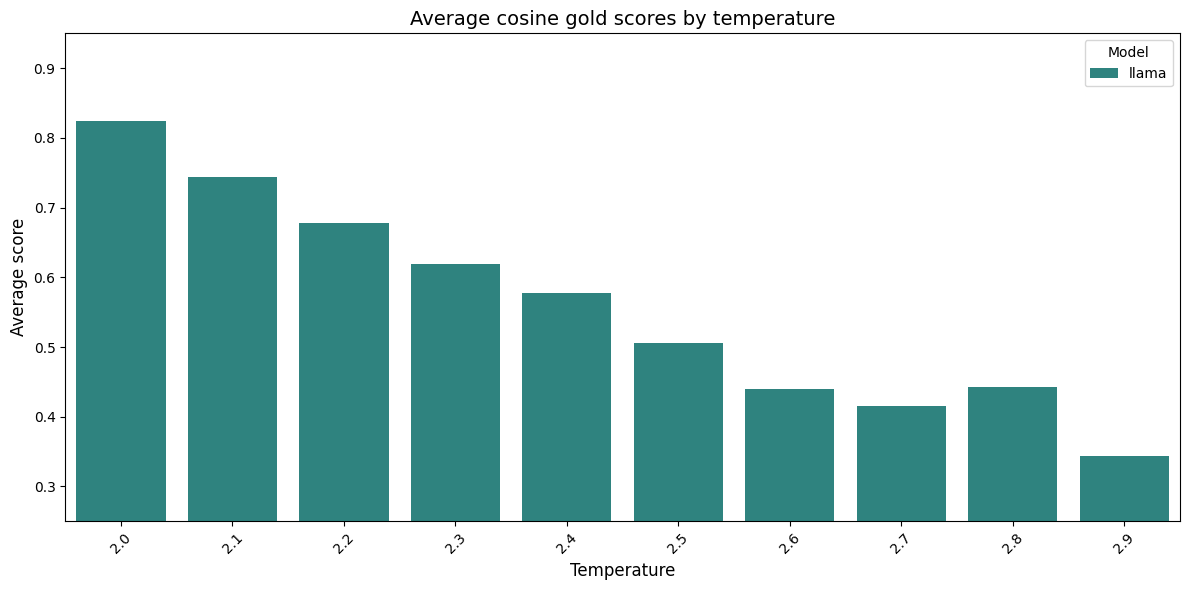

In [ ]:
start_index = 760
end_index = 1160
print('Sample count', end_index - start_index)
df_llama = df_llama[start_index: end_index]
grouped_llama = df_llama.groupby('temperature')[['gold_standard_cos']].mean()
grouped_llama['Model'] = 'llama'
all_grouped_scores = pd.concat(
    [
        grouped_llama
    ]
)
all_grouped_scores = all_grouped_scores.reset_index()
melted_scores = all_grouped_scores.melt(
    id_vars=['temperature', 'Model'],
    var_name='Metric',
    value_name='Average'
)
plt.figure(figsize=(12, 6))
sns.barplot(
    x='temperature',
    y='Average',
    hue='Model',
    data=melted_scores,
    palette='viridis'
)
plt.title('Average cosine gold scores by temperature', fontsize=14)
plt.ylabel('Average score', fontsize=12)
plt.ylim(0.25, 0.95)
plt.xlabel('Temperature', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

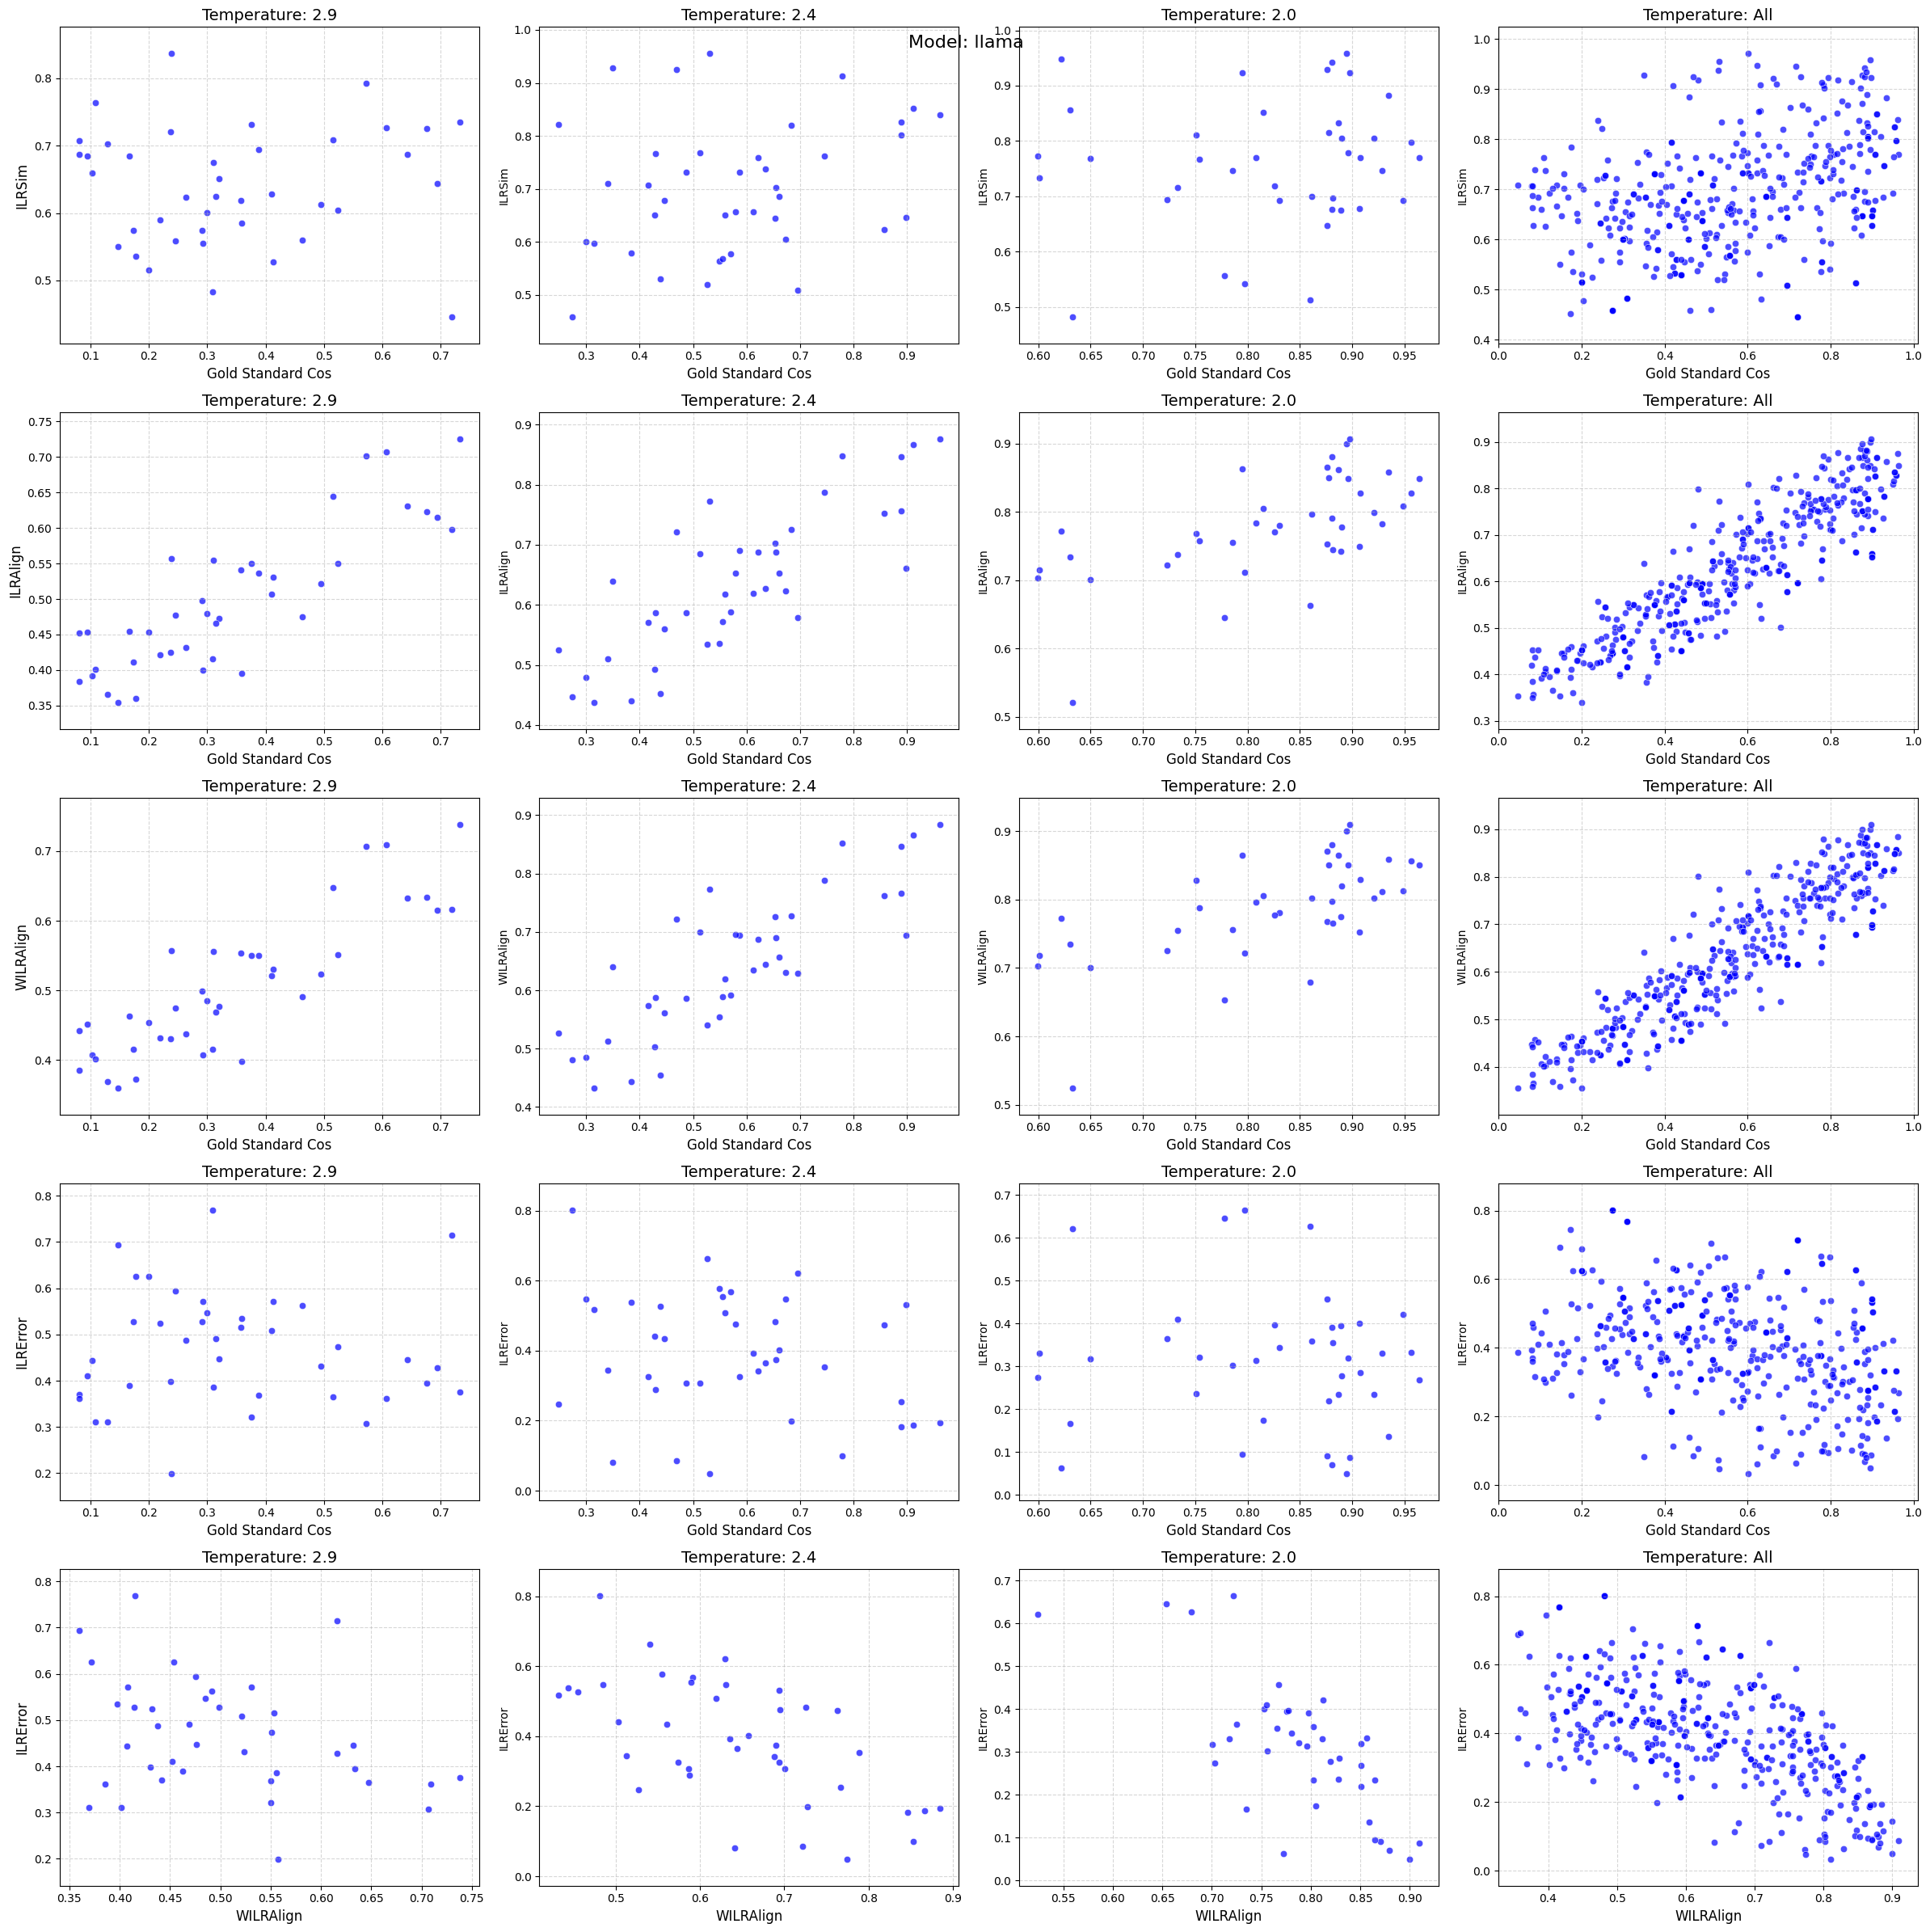

In [ ]:
llama_values = get_key_temperatures(grouped_llama)
llama_temperature_selection = [llama_values[0], llama_values[1], llama_values[2]]
temperature_selections = {
    'llama': (llama_temperature_selection, df_llama)
}

max_temps = max(len(temp_selection) for temp_selection, _ in temperature_selections.values()) + 1

for model, (temp_selection, df) in temperature_selections.items():
    fig, axes = plt.subplots(5, max(len(temp_selection) + 1, max_temps),
                              figsize=((max_temps) * 6, 4 * 6),
                              sharey=False)

    def get_dynamic_limits(data, y_column):
        min_val, max_val = data[y_column].min(), data[y_column].max()
        margin = (max_val - min_val) * 0.1
        return min_val - margin, max_val + margin

    for row, y_column, y_label in zip(
        range(6),
        ['ILRSim', 'ILRAlign', 'WILRAlign', 'ILRError', 'ILRError'],
        ['ILRSim', 'ILRAlign', 'WILRAlign', 'ILRError', 'ILRError']
    ):
        for col, temp in enumerate(temp_selection + ['All']):
            ax = axes[row, col] if len(temp_selection) > 1 else axes[row]
            filtered_df = df if temp == 'All' else df[df['temperature'] == temp]
            sns.scatterplot(
                x='gold_standard_cos' if row < 4 else 'WILRAlign',
                y=y_column,
                data=filtered_df,
                ax=ax,
                color='blue',
                alpha=0.7
            )
            y_min, y_max = get_dynamic_limits(filtered_df, y_column)
            ax.set_ylim(y_min, y_max)
            ax.set_title(f'Temperature: {temp}', fontsize=14)
            ax.set_xlabel('Gold Standard Cos' if row < 4 else 'WILRAlign', fontsize=12)
            if col == 0:
                ax.set_ylabel(y_label, fontsize=12)
            ax.grid(True, linestyle='--', alpha=0.5)

    for row in range(4):
        for col in range(len(temp_selection) + 1, max_temps):
            fig.delaxes(axes[row, col] if len(temp_selection) > 1 else axes[row])

    plt.tight_layout()
    plt.suptitle(f'Model: {model}', fontsize=16)
    plt.show()

In [ ]:
for model, (temp_selection, df) in temperature_selections.items():
    print(f'Pearson Correlation Coefficients for Model: {model} \n')

    correlation_types = {
        'Gold Standard Cos vs ILRSim': ('gold_standard_cos', 'ILRSim'),
        'Gold Standard Cos vs ILRAlign': ('gold_standard_cos', 'ILRAlign'),
        'Gold Standard Cos vs WILRAlign': ('gold_standard_cos', 'WILRAlign'),
        'Gold Standard Cos vs ILRError': ('gold_standard_cos', 'ILRError')
    }

    for key, (col1, col2) in correlation_types.items():
        print(f'--- {key} ---')
        for temp in temp_selection + ['All']:
            filtered_df = df if temp == 'All' else df[df['temperature'] == temp]
            correlation = filtered_df[col1].corr(filtered_df[col2])
            print(f'Temperature {temp}: {correlation:.4f}')
        print()

Pearson Correlation Coefficients for Model: llama 

--- Gold Standard Cos vs ILRSim ---
Temperature 2.9: 0.0314
Temperature 2.4: 0.2433
Temperature 2.0: 0.1037
Temperature All: 0.3824

--- Gold Standard Cos vs ILRAlign ---
Temperature 2.9: 0.8486
Temperature 2.4: 0.8120
Temperature 2.0: 0.6129
Temperature All: 0.8994

--- Gold Standard Cos vs WILRAlign ---
Temperature 2.9: 0.8604
Temperature 2.4: 0.8329
Temperature 2.0: 0.6403
Temperature All: 0.9112

--- Gold Standard Cos vs ILRError ---
Temperature 2.9: -0.0114
Temperature 2.4: -0.2290
Temperature 2.0: -0.0804
Temperature All: -0.3468



MISTRAL AS A MODEL


Sample count 400


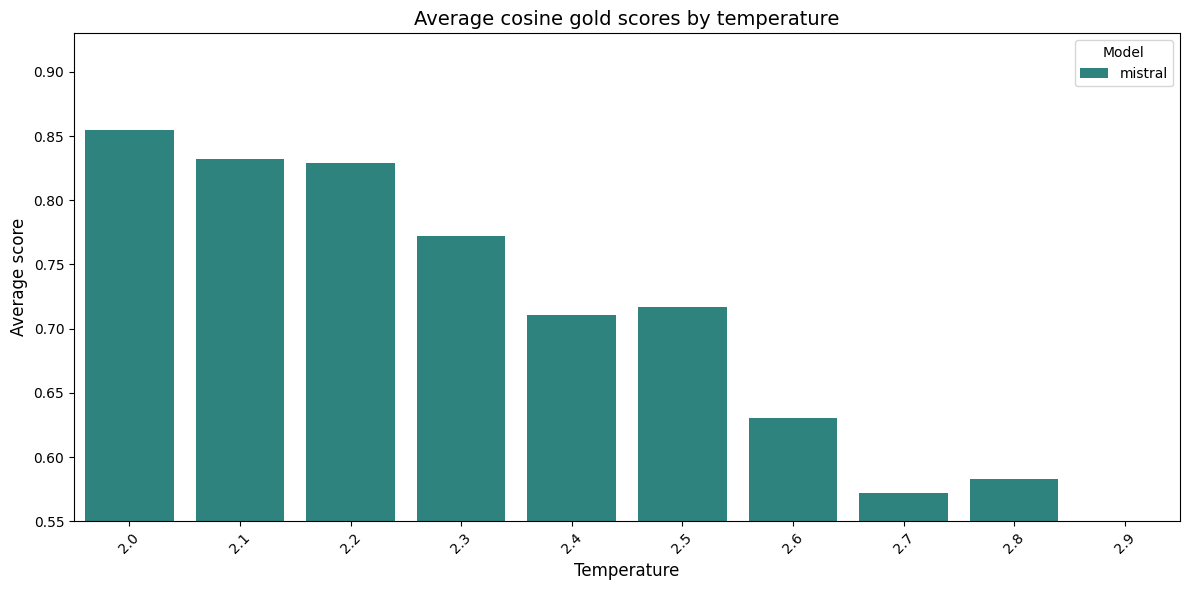

In [ ]:
start_index = 760
end_index = 1160
print('Sample count', end_index - start_index)
df_mistral = df_mistral[start_index: end_index]
grouped_mistral = df_mistral.groupby('temperature')[['gold_standard_cos']].mean()
grouped_mistral['Model'] = 'mistral'
all_grouped_scores = pd.concat(
    [
        grouped_mistral
    ]
)
all_grouped_scores = all_grouped_scores.reset_index()
melted_scores = all_grouped_scores.melt(
    id_vars=['temperature', 'Model'],
    var_name='Metric',
    value_name='Average'
)
plt.figure(figsize=(12, 6))
sns.barplot(
    x='temperature',
    y='Average',
    hue='Model',
    data=melted_scores,
    palette='viridis'
)
plt.title('Average cosine gold scores by temperature', fontsize=14)
plt.ylabel('Average score', fontsize=12)
plt.ylim(0.55, 0.93)
plt.xlabel('Temperature', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

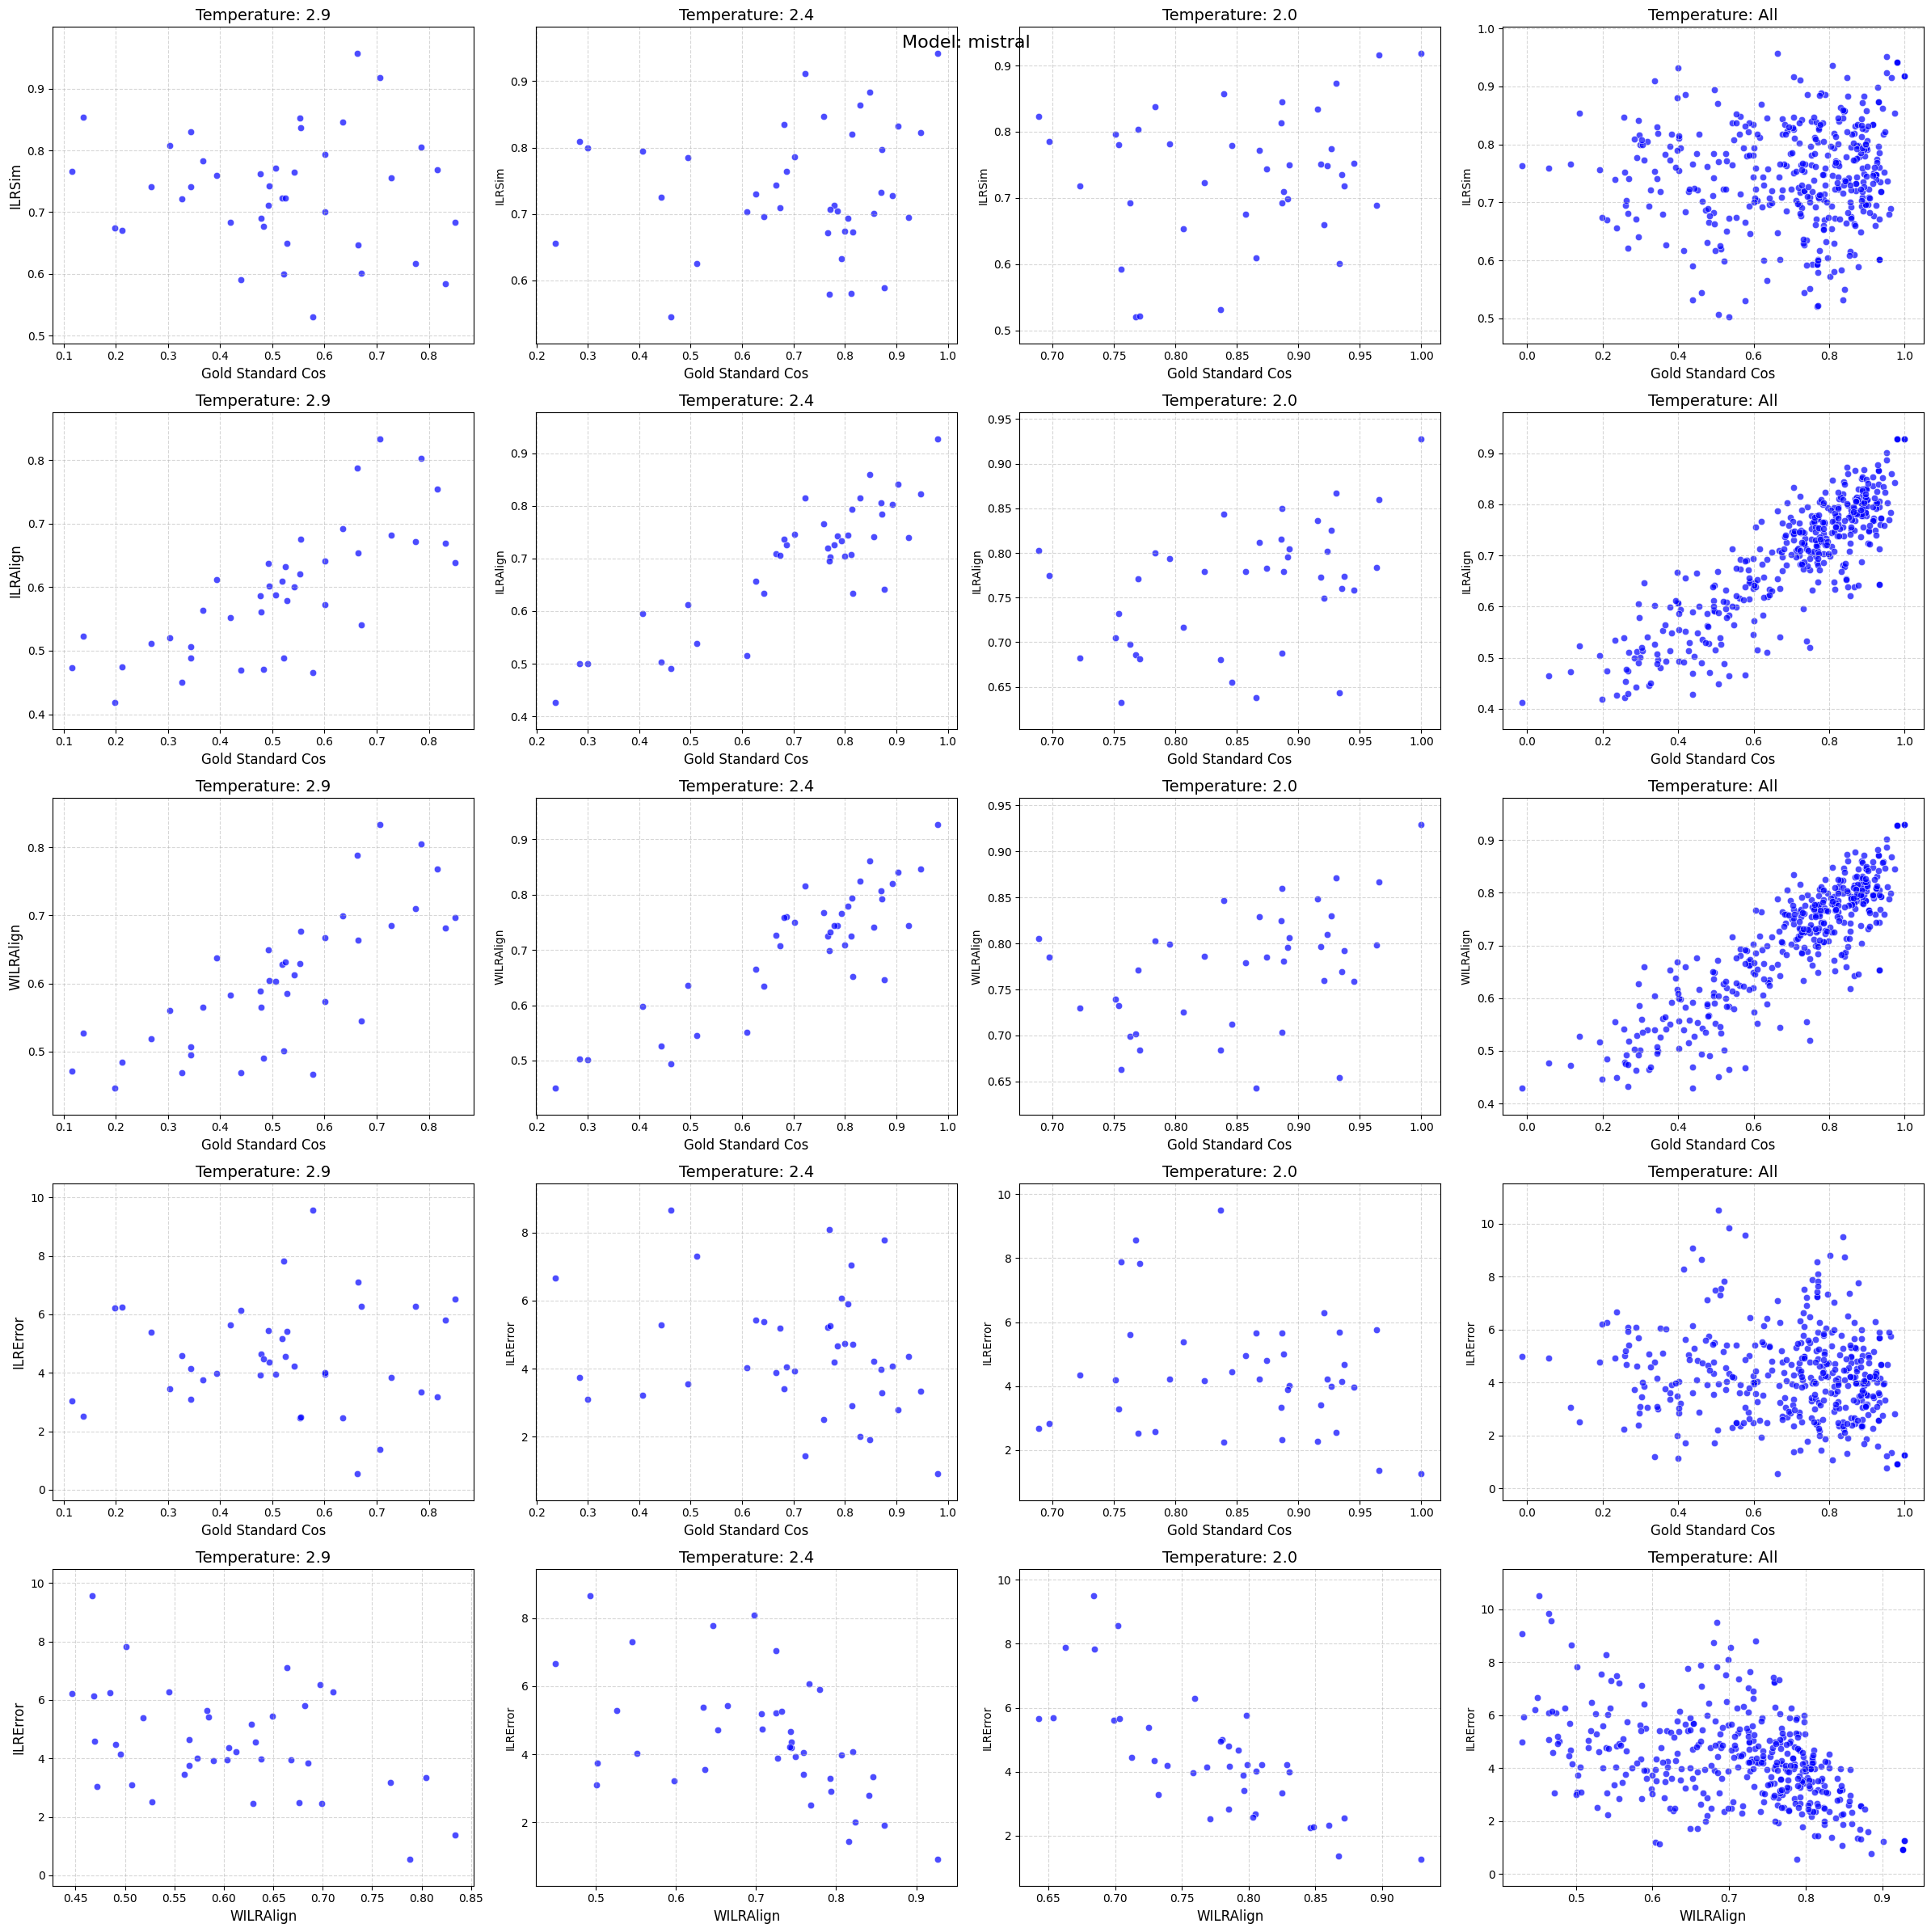

In [ ]:
mistral_values = get_key_temperatures(grouped_mistral)
mistral_temperature_selection = [mistral_values[0], mistral_values[1], mistral_values[2]]
temperature_selections = {
    'mistral': (mistral_temperature_selection, df_mistral)
}

max_temps = max(len(temp_selection) for temp_selection, _ in temperature_selections.values()) + 1

for model, (temp_selection, df) in temperature_selections.items():
    fig, axes = plt.subplots(5, max(len(temp_selection) + 1, max_temps),
                              figsize=((max_temps) * 6, 4 * 6),
                              sharey=False)

    def get_dynamic_limits(data, y_column):
        min_val, max_val = data[y_column].min(), data[y_column].max()
        margin = (max_val - min_val) * 0.1
        return min_val - margin, max_val + margin

    for row, y_column, y_label in zip(
        range(6),
        ['ILRSim', 'ILRAlign', 'WILRAlign', 'ILRError', 'ILRError'],
        ['ILRSim', 'ILRAlign', 'WILRAlign', 'ILRError', 'ILRError']
    ):
        for col, temp in enumerate(temp_selection + ['All']):
            ax = axes[row, col] if len(temp_selection) > 1 else axes[row]
            filtered_df = df if temp == 'All' else df[df['temperature'] == temp]
            sns.scatterplot(
                x='gold_standard_cos' if row < 4 else 'WILRAlign',
                y=y_column,
                data=filtered_df,
                ax=ax,
                color='blue',
                alpha=0.7
            )
            y_min, y_max = get_dynamic_limits(filtered_df, y_column)
            ax.set_ylim(y_min, y_max)
            ax.set_title(f'Temperature: {temp}', fontsize=14)
            ax.set_xlabel('Gold Standard Cos' if row < 4 else 'WILRAlign', fontsize=12)
            if col == 0:
                ax.set_ylabel(y_label, fontsize=12)
            ax.grid(True, linestyle='--', alpha=0.5)

    for row in range(4):
        for col in range(len(temp_selection) + 1, max_temps):
            fig.delaxes(axes[row, col] if len(temp_selection) > 1 else axes[row])

    plt.tight_layout()
    plt.suptitle(f'Model: {model}', fontsize=16)
    plt.show()

In [ ]:
for model, (temp_selection, df) in temperature_selections.items():
    print(f'Pearson Correlation Coefficients for Model: {model} \n')

    correlation_types = {
        'Gold Standard Cos vs ILRSim': ('gold_standard_cos', 'ILRSim'),
        'Gold Standard Cos vs ILRAlign': ('gold_standard_cos', 'ILRAlign'),
        'Gold Standard Cos vs WILRAlign': ('gold_standard_cos', 'WILRAlign'),
        'Gold Standard Cos vs ILRError': ('gold_standard_cos', 'ILRError')
    }

    for key, (col1, col2) in correlation_types.items():
        print(f'--- {key} ---')
        for temp in temp_selection + ['All']:
            filtered_df = df if temp == 'All' else df[df['temperature'] == temp]
            correlation = filtered_df[col1].corr(filtered_df[col2])
            print(f'Temperature {temp}: {correlation:.4f}')
        print()

Pearson Correlation Coefficients for Model: mistral 

--- Gold Standard Cos vs ILRSim ---
Temperature 2.9: -0.0892
Temperature 2.4: 0.1250
Temperature 2.0: 0.2039
Temperature All: 0.0760

--- Gold Standard Cos vs ILRAlign ---
Temperature 2.9: 0.7463
Temperature 2.4: 0.8701
Temperature 2.0: 0.4311
Temperature All: 0.8658

--- Gold Standard Cos vs WILRAlign ---
Temperature 2.9: 0.7618
Temperature 2.4: 0.8754
Temperature 2.0: 0.4270
Temperature All: 0.8717

--- Gold Standard Cos vs ILRError ---
Temperature 2.9: 0.0391
Temperature 2.4: -0.2257
Temperature 2.0: -0.1925
Temperature All: -0.1394



FALCON AS THE MODEL

Sample count 400


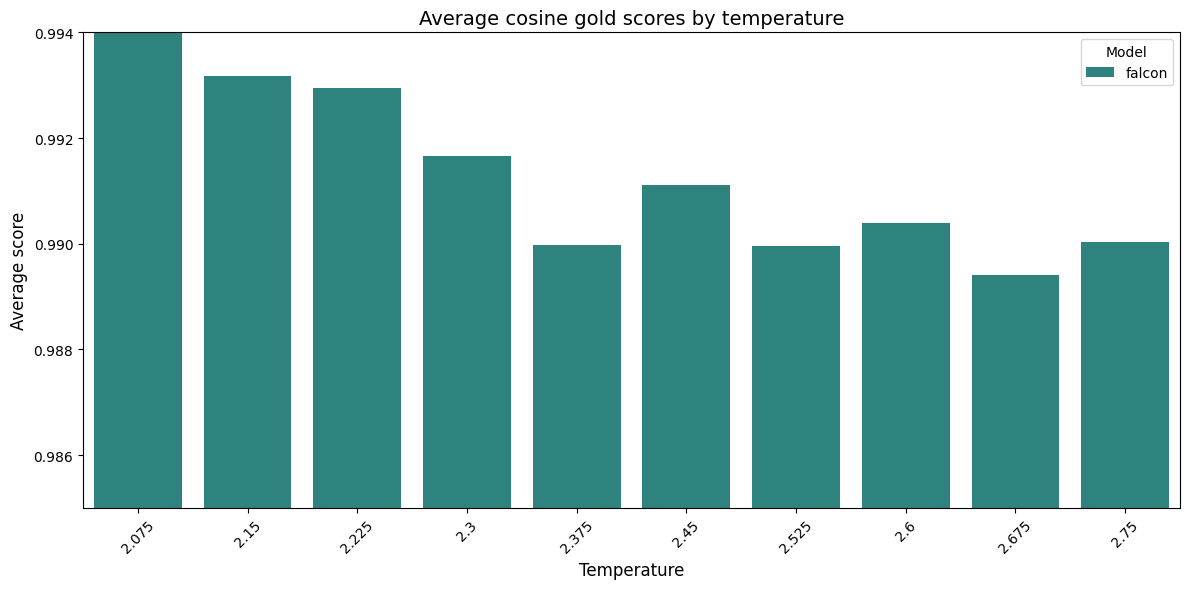

In [ ]:
start_index = 40
end_index = 440
print('Sample count', end_index - start_index)
df_falcon = df_falcon[start_index: end_index]
grouped_falcon = df_falcon.groupby('temperature')[['gold_standard_cos']].mean()
grouped_falcon['Model'] = 'falcon'
all_grouped_scores = pd.concat(
    [
        grouped_falcon
    ]
)
all_grouped_scores = all_grouped_scores.reset_index()
melted_scores = all_grouped_scores.melt(
    id_vars=['temperature', 'Model'],
    var_name='Metric',
    value_name='Average'
)
plt.figure(figsize=(12, 6))
sns.barplot(
    x='temperature',
    y='Average',
    hue='Model',
    data=melted_scores,
    palette='viridis'
)
plt.title('Average cosine gold scores by temperature', fontsize=14)
plt.ylabel('Average score', fontsize=12)
plt.ylim(0.985, 0.994)
plt.xlabel('Temperature', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

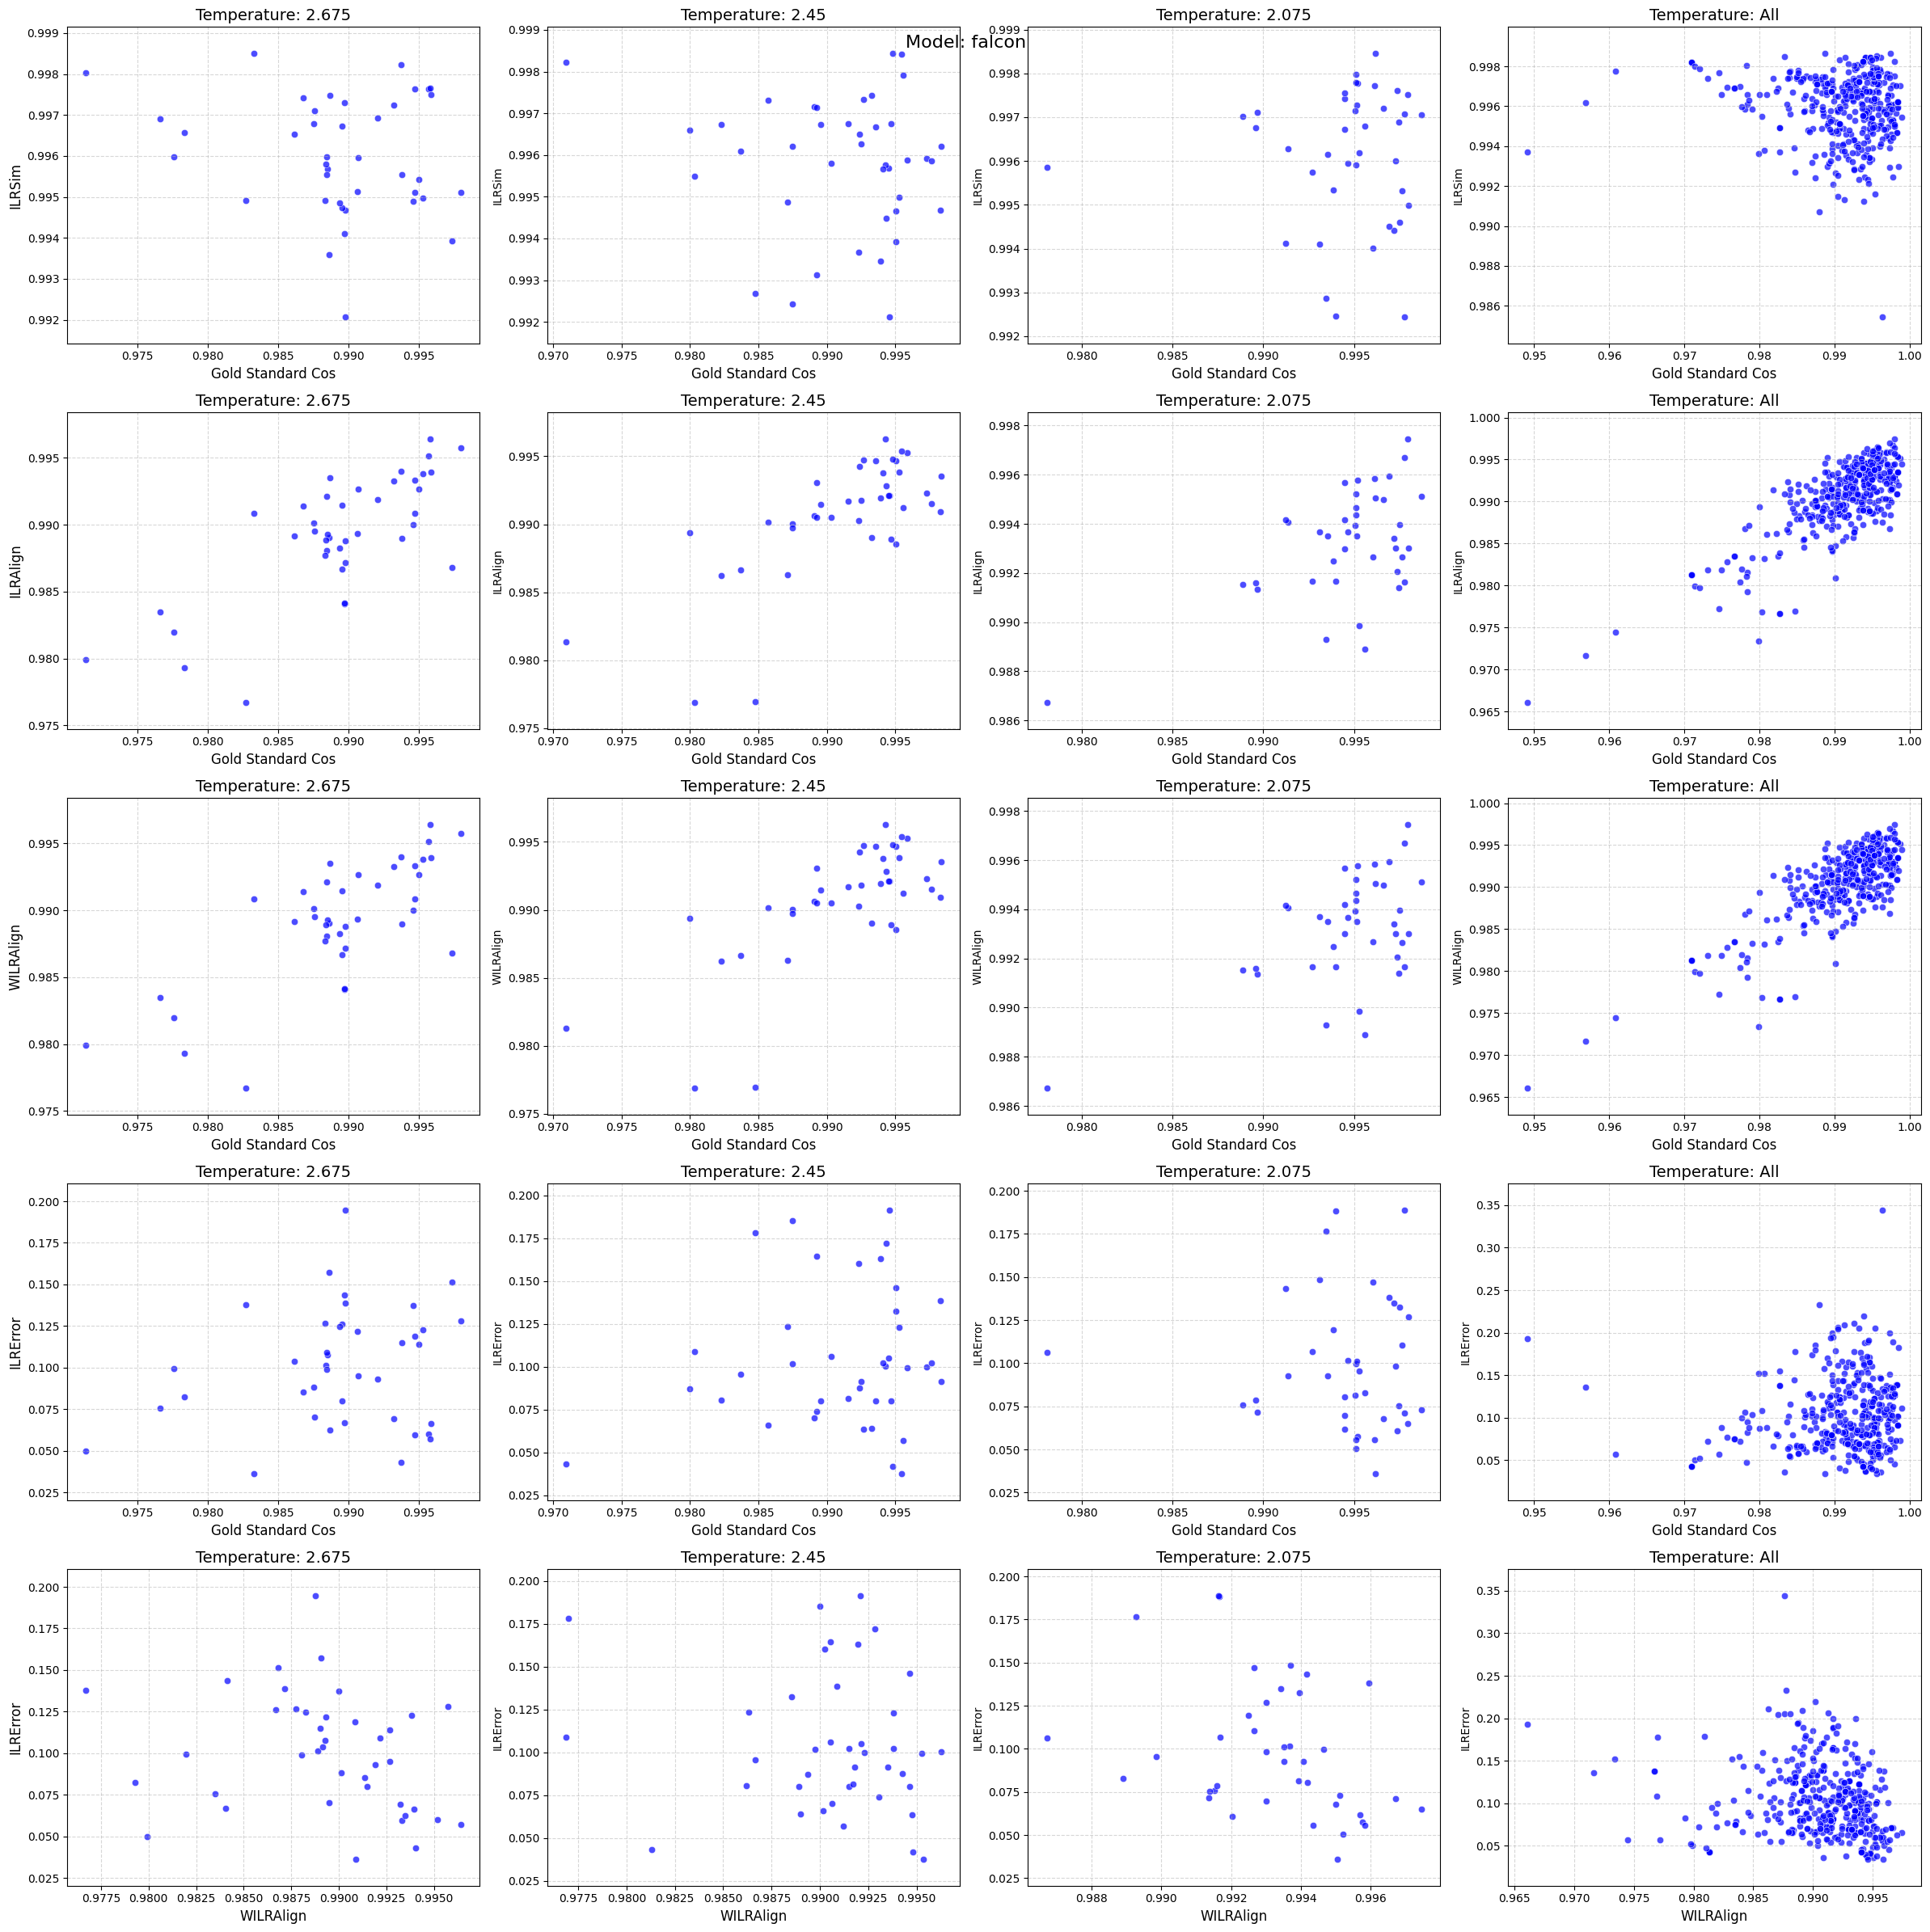

In [ ]:
falcon_values = get_key_temperatures(grouped_falcon)
falcon_temperature_selection = [falcon_values[0], falcon_values[1], falcon_values[2]]
temperature_selections = {
    'falcon': (falcon_temperature_selection, df_falcon)
}

max_temps = max(len(temp_selection) for temp_selection, _ in temperature_selections.values()) + 1

for model, (temp_selection, df) in temperature_selections.items():
    fig, axes = plt.subplots(5, max(len(temp_selection) + 1, max_temps),
                              figsize=((max_temps) * 6, 4 * 6),
                              sharey=False)

    def get_dynamic_limits(data, y_column):
        min_val, max_val = data[y_column].min(), data[y_column].max()
        margin = (max_val - min_val) * 0.1
        return min_val - margin, max_val + margin

    for row, y_column, y_label in zip(
        range(6),
        ['ILRSim', 'ILRAlign', 'WILRAlign', 'ILRError', 'ILRError'],
        ['ILRSim', 'ILRAlign', 'WILRAlign', 'ILRError', 'ILRError']
    ):
        for col, temp in enumerate(temp_selection + ['All']):
            ax = axes[row, col] if len(temp_selection) > 1 else axes[row]
            filtered_df = df if temp == 'All' else df[df['temperature'] == temp]
            sns.scatterplot(
                x='gold_standard_cos' if row < 4 else 'WILRAlign',
                y=y_column,
                data=filtered_df,
                ax=ax,
                color='blue',
                alpha=0.7
            )
            y_min, y_max = get_dynamic_limits(filtered_df, y_column)
            ax.set_ylim(y_min, y_max)
            ax.set_title(f'Temperature: {temp}', fontsize=14)
            ax.set_xlabel('Gold Standard Cos' if row < 4 else 'WILRAlign', fontsize=12)
            if col == 0:
                ax.set_ylabel(y_label, fontsize=12)
            ax.grid(True, linestyle='--', alpha=0.5)

    for row in range(4):
        for col in range(len(temp_selection) + 1, max_temps):
            fig.delaxes(axes[row, col] if len(temp_selection) > 1 else axes[row])

    plt.tight_layout()
    plt.suptitle(f'Model: {model}', fontsize=16)
    plt.show()

In [ ]:
for model, (temp_selection, df) in temperature_selections.items():
    print(f'Pearson Correlation Coefficients for Model: {model} \n')

    correlation_types = {
        'Gold Standard Cos vs ILRSim': ('gold_standard_cos', 'ILRSim'),
        'Gold Standard Cos vs ILRAlign': ('gold_standard_cos', 'ILRAlign'),
        'Gold Standard Cos vs WILRAlign': ('gold_standard_cos', 'WILRAlign'),
        'Gold Standard Cos vs ILRError': ('gold_standard_cos', 'ILRError')
    }

    for key, (col1, col2) in correlation_types.items():
        print(f'--- {key} ---')
        for temp in temp_selection + ['All']:
            filtered_df = df if temp == 'All' else df[df['temperature'] == temp]
            correlation = filtered_df[col1].corr(filtered_df[col2])
            print(f'Temperature {temp}: {correlation:.4f}')
        print()

Pearson Correlation Coefficients for Model: falcon 

--- Gold Standard Cos vs ILRSim ---
Temperature 2.675: -0.1885
Temperature 2.45: -0.1160
Temperature 2.075: 0.0184
Temperature All: -0.1080

--- Gold Standard Cos vs ILRAlign ---
Temperature 2.675: 0.7473
Temperature 2.45: 0.7201
Temperature 2.075: 0.5421
Temperature All: 0.7846

--- Gold Standard Cos vs WILRAlign ---
Temperature 2.675: 0.7472
Temperature 2.45: 0.7201
Temperature 2.075: 0.5424
Temperature All: 0.7847

--- Gold Standard Cos vs ILRError ---
Temperature 2.675: 0.1934
Temperature 2.45: 0.1286
Temperature 2.075: -0.0274
Temperature All: 0.0829



SUMMARY

<ipython-input-28-9fd3503415c1>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-28-9fd3503415c1>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-28-9fd3503415c1>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-28-9fd3503415c1>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


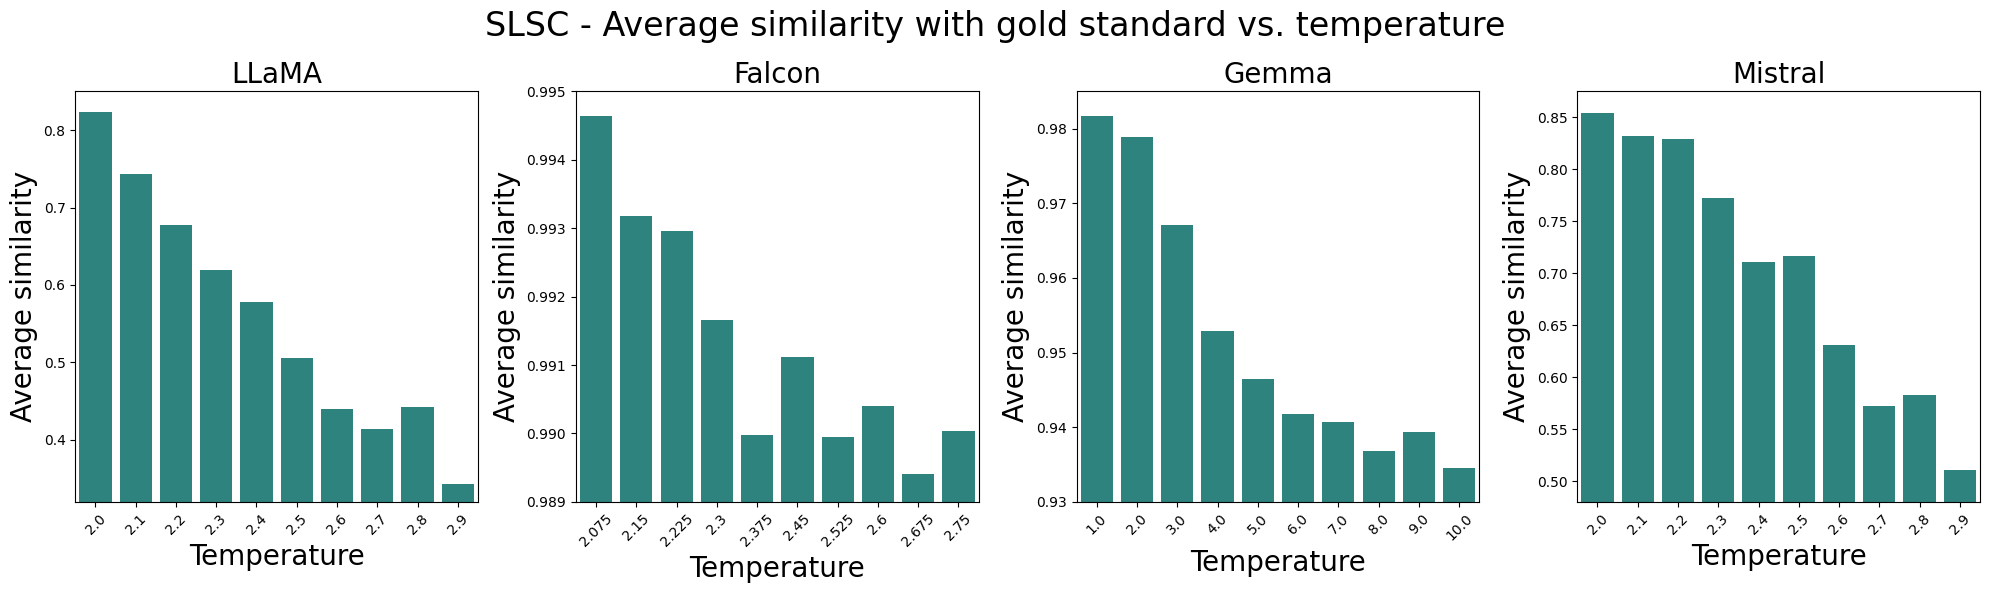

In [ ]:
def plot_model_scores(df, model_name, ax, y1, y2):
    grouped_df = df.groupby('temperature')[['gold_standard_cos']].mean()
    grouped_df['Model'] = model_name
    grouped_df = grouped_df.reset_index()
    melted_scores = grouped_df.melt(
        id_vars=['temperature', 'Model'],
        var_name='Metric',
        value_name='Average'
    )

    sns.barplot(
        x='temperature',
        y='Average',
        hue='Model',
        data=melted_scores,
        palette='viridis',
        ax=ax
    )
    ax.set_title(f'{model_name}', fontsize=20)
    ax.legend_.remove()
    ax.set_ylabel('Average similarity', fontsize=20)
    ax.set_ylim(y1, y2)
    ax.set_xlabel('Temperature', fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

fig, axes = plt.subplots(1, 4, figsize=(20, 6))


plot_model_scores(df_llama, 'LLaMA', axes[0], 0.32, 0.85)
plot_model_scores(df_falcon, 'Falcon', axes[1], 0.989, 0.995)
plot_model_scores(df_gemma, 'Gemma', axes[2], 0.93, 0.985)
plot_model_scores(df_mistral, 'Mistral', axes[3], 0.48, 0.875)

fig.suptitle('SLSC - Average similarity with gold standard vs. temperature', fontsize=24)
plt.tight_layout()
plt.show()

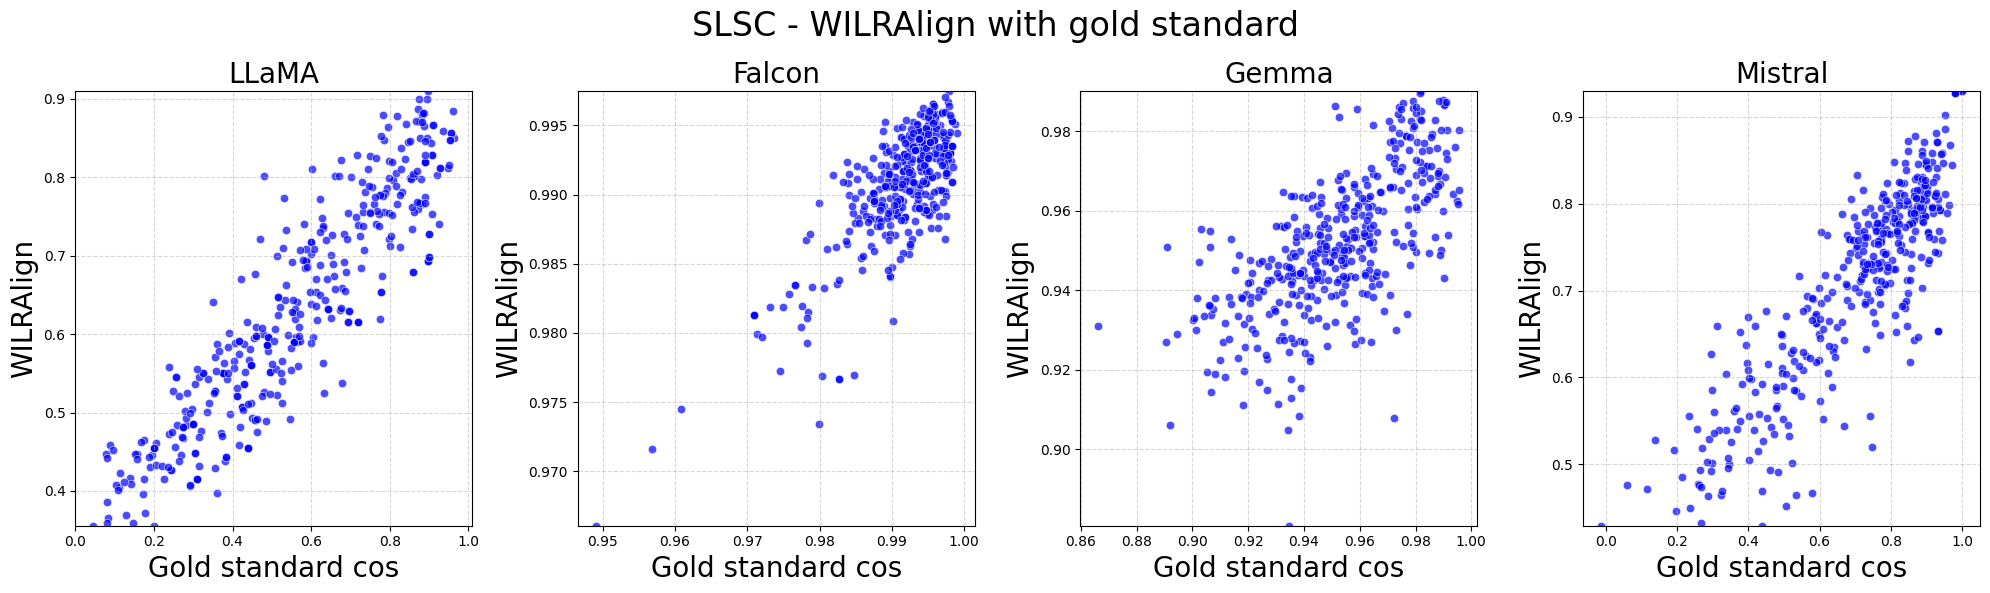

In [ ]:
def plot_model_wilrAlign_corr(df, model_name, ax):
    sns.scatterplot(
        x='gold_standard_cos',
        y='WILRAlign',
        data=df,
        ax=ax,
        color='blue',
        alpha=0.7
    )

    ax.set_ylim(df['WILRAlign'].min(), df['WILRAlign'].max())
    ax.set_title(f'{model_name}', fontsize=20)
    ax.set_xlabel('Gold standard cos', fontsize=20)
    ax.set_ylabel('WILRAlign', fontsize=20)
    ax.grid(True, linestyle='--', alpha=0.5)

fig, axes = plt.subplots(1, 4, figsize=(20, 6))
plot_model_wilrAlign_corr(df_llama, 'LLaMA', axes[0])
plot_model_wilrAlign_corr(df_falcon, 'Falcon', axes[1])
plot_model_wilrAlign_corr(df_gemma, 'Gemma', axes[2])
plot_model_wilrAlign_corr(df_mistral, 'Mistral', axes[3])
fig.suptitle('SLSC - WILRAlign with gold standard', fontsize=24)
plt.tight_layout()
plt.show()

In [ ]:
rename_dict = {
    'judge_answer_answerGenerated_llama_cos': 'ans_llama',
    'judge_answer_answerGenerated_falcon_cos': 'ans_falcon',
    'judge_answer_answerGenerated_gemma_cos': 'ans_gemma',
    'judge_answer_answerGenerated_mistral_cos': 'ans_mistral',
    'question_answerGenerated_llama_cos': 'ques_llama',
    'question_answerGenerated_falcon_cos': 'ques_falcon',
    'question_answerGenerated_gemma_cos': 'ques_gemma',
    'question_answerGenerated_mistral_cos': 'ques_mistral'
}

df_llama = df_llama.rename(columns=rename_dict)
df_falcon = df_falcon.rename(columns=rename_dict)
df_gemma = df_gemma.rename(columns=rename_dict)
df_mistral = df_mistral.rename(columns=rename_dict)

dfs = {'Llama': df_llama, 'Falcon': df_falcon, 'Gemma': df_gemma, 'Mistral': df_mistral}
correlation_raw_columns = list(rename_dict.values())
gold_standard_col = 'gold_standard_cos'
correlation_raw_df = pd.DataFrame(index=dfs.keys(), columns=correlation_raw_columns)
for df_name, df in dfs.items():
    for col in correlation_raw_columns:
        if col in df.columns and gold_standard_col in df.columns:
            correlation_raw_df.loc[df_name, col] = round(df[col].corr(df[gold_standard_col]), 4)


correlation_raw_df = correlation_raw_df.astype(float)
correlation_raw_df

,ans_llama,ans_falcon,ans_gemma,ans_mistral,ques_llama,ques_falcon,ques_gemma,ques_mistral
Llama,NaN,-0.1052,0.1040,0.0477,NaN,0.3238,0.3072,0.2728
Falcon,-0.1026,NaN,-0.1393,-0.1267,-0.0841,NaN,-0.0250,-0.1310
Gemma,0.2546,0.0228,NaN,0.2054,0.3383,0.3425,NaN,0.3648
Mistral,0.2792,0.1841,0.1403,NaN,-0.1034,0.0677,0.1448,NaN


In [ ]:
temperature_selections = {
    'LLaMA': df_llama,
    'Gemma': df_gemma,
    'Falcon': df_falcon,
    'Mistral': df_mistral
}
correlation_types = {
    'Answer Sim Mean': ('gold_standard_cos', 'answer_judge_cos_mean'),
    'BM25 Mean': ('gold_standard_cos', 'question_bm25_score_mean'),
    'ROUGE Mean': ('gold_standard_cos', 'question_rouge_score_mean'),
    'BLEU Mean': ('gold_standard_cos', 'question_bleu_score_mean'),
    'ILRSim': ('gold_standard_cos', 'ILRSim'),
    'ILRError': ('gold_standard_cos', 'ILRError'),
    'ILRAlign': ('gold_standard_cos', 'ILRAlign'),
    'WILRAlign': ('gold_standard_cos', 'WILRAlign')
}
results = []

for model, df in temperature_selections.items():
    row = {'Model': model}
    for key, (col1, col2) in correlation_types.items():
        correlation = df[col1].corr(df[col2])
        row[key] = round(correlation, 4)
    results.append(row)
table_df = pd.DataFrame(results)
average_row = {'Model': 'Average'}
for key in correlation_types.keys():
    average_correlation = table_df[key].mean()
    average_row[key] = round(average_correlation, 4)

table_df = pd.concat([table_df, pd.DataFrame([average_row])], ignore_index=True)
table_df

,Model,Answer Sim Mean,BM25 Mean,ROUGE Mean,BLEU Mean,ILRSim,ILRError,ILRAlign,WILRAlign
0,LLaMA,0.0318,0.0233,0.4167,0.4346,0.3824,-0.3468,0.8994,0.9112
1,Gemma,0.1930,-0.0249,0.4801,0.4617,0.4441,-0.4085,0.6600,0.6729
2,Falcon,-0.1435,-0.1778,-0.0475,-0.0100,-0.1080,0.0829,0.7846,0.7847
3,Mistral,0.2429,-0.1519,0.0800,0.1414,0.0760,-0.1394,0.8658,0.8717
4,Average,0.0811,-0.0828,0.2323,0.2569,0.1986,-0.2030,0.8025,0.8101
